# A qualitative investigation of locality and anti-locality effects with lossy-context surprisal
This thesis aims to investigate whether or not lossy-context surprisal (Futrell et al., 2021), at least qualitatively, has the requisite mechanisms necessary to explain both locality and anti-locality effects and interactions between them within a coherent framework.

In [2]:
import toylossy
import seaborn as sns
import grammars
from nltk.grammar import PCFG
import expdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

My implementation has a progressive noise model where the retention probability of word $w_j$ given that $w_i$ is the last word in the context is given as
$$
e_j = \delta \nu^{i-j}
$$
where $\delta$ is the maximum retention probability and $\nu$ the falloff of the retention probability with increasing distance. In the code these are given as `max_retention_probability` and `rate_falloff` respectively. A symbol that is not retained is simply deleted.

The language model $L$ is given as a probabilistic context-free grammar. These will also be added to this document at a later time.

## The syntactic complexity of Russian relative clauses

In [3]:
pcfg_russian = PCFG.fromstring(
    grammars.gen_russian_grammar_exp2(
        p_src = 0.58, 
        p_src_local = 0.99,
        p_src_case_marked = 0.9,
        p_orc_local = 0.36,
        p_orc_case_marked = 0.83,
        p_one_arg = 0.97, 
        p_adj_interveners = 0.16, 
        p_one_adj = 0.95
    )
)

del_rate = 0.4
max_retention_probability = 1-del_rate
rate_falloff = 0.9

max_depth = None

model_russian = toylossy.ProgressiveNoiseModel(pcfg_russian, max_retention_probability, rate_falloff, max_depth = max_depth)

The parameters were chosen in accordance with the corpus study results of Levy et al. (2013), as reported in Table 1 (p. 467). $p(\text{SRC)}=\frac{163}{279}\approx 0.58$, $p(\text{SRC}_\text{Local})=\frac{154}{163}\approx 0.94$, $p(\text{ORC}_\text{Local})=\frac{42}{116}\approx 0.36$, $p(\text{SRC case marked})=\frac{154+9}{182}\approx 0.9$, $p(\text{ORC case marked})=\frac{42+74}{139}\approx 0.83$.

The other probabilities were calculated using Universal Dependencies (see the very end of this notebook for the used queries). The probability of the verb being ditransitive is given as 

### Experiment 1
In this experiment, local and non-local RC configurations were tested to ascertain the reading time at the verb, first and foremost. The results were the following:

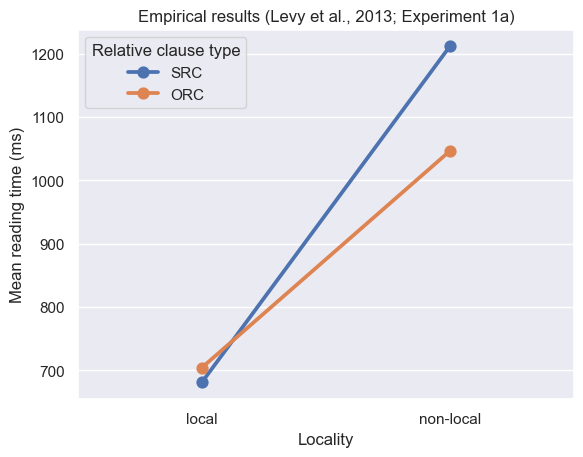

In [4]:
sns.set_theme()

sns.pointplot(expdata.levy_exp1a_verb,
              x = "Locality", 
              y = "Mean reading time (ms)", 
              hue = "Relative clause type"
).set_title("Empirical results (Levy et al., 2013; Experiment 1a)");

We run the model with the parameters assigned as above and get the following plot:

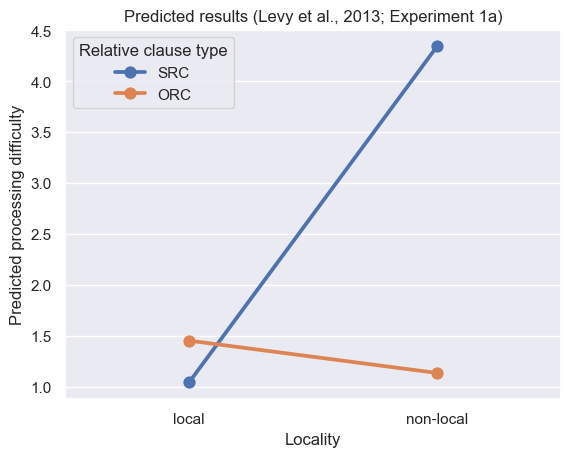

In [5]:
src_local = model_russian.calculate_processing_difficulty("RPNom V".split(), False)
src_non_local = model_russian.calculate_processing_difficulty("RPNom DO V".split())

orc_local = model_russian.calculate_processing_difficulty("RPAcc V".split())
orc_non_local = model_russian.calculate_processing_difficulty("RPAcc Subj V".split(), False)

sim_data_exp1a = pd.DataFrame({
    "Predicted processing difficulty": [src_local, src_non_local, orc_local, orc_non_local],
    "Relative clause type": ["SRC", "SRC", "ORC", "ORC"],
    "Locality": ["local", "non-local", "local", "non-local"]
})

sns.pointplot(sim_data_exp1a,
              x = "Locality", 
              y = "Predicted processing difficulty", 
              hue = "Relative clause type"
).set_title("Predicted results (Levy et al., 2013; Experiment 1a)");

We can look at how changing `max_retention_probability` and `rate_falloff` influence the difference between local and non-local ORCs.

In [6]:
def gen_diffs(sequence1: list[str], 
              sequence2: list[str],
              pcfg: PCFG,
              max_retention_probabilities: np.array,
              rate_falloffs: np.array,
              max_depth = None):
    diffs = np.zeros((len(max_retention_probabilities), len(rate_falloffs)))
    model = toylossy.ProgressiveNoiseModel(pcfg, 0, 0, max_depth = max_depth)
    for (i, max_rp) in tqdm(enumerate(max_retention_probabilities)):
        for (j, rf) in enumerate(rate_falloffs):
            model.set_max_retention_probability(max_rp)
            model.set_rate_falloff(rf)
            diff = model.calculate_processing_difficulty(sequence1) - model.calculate_processing_difficulty(sequence2)
            diffs[i, j] = diff

    return diffs

step = 0.01

max_retention_probabilities = np.arange(0, 1.0 + step, step)
rate_falloffs = np.arange(0, 1 + step, step)

from matplotlib.colors import CenteredNorm

yticklabels = [f"{val:.2f}" if i % 5 == 0 else "" for (i, val) in enumerate(max_retention_probabilities)]
xticklabels = [f"{val:.2f}" if i % 5 == 0 else "" for (i, val) in enumerate(rate_falloffs)]

norm = CenteredNorm(vcenter = 0)

In [7]:
diffs_orcs_russian = gen_diffs("RPAcc Subj V".split(), "RPAcc V".split(), pcfg_russian, max_retention_probabilities, rate_falloffs, max_depth = max_depth)
diffs_srcs_russian = gen_diffs("RPNom DO V".split(), "RPNom V".split(), pcfg_russian, max_retention_probabilities, rate_falloffs, max_depth = max_depth)

101it [02:28,  1.47s/it]
101it [02:20,  1.39s/it]


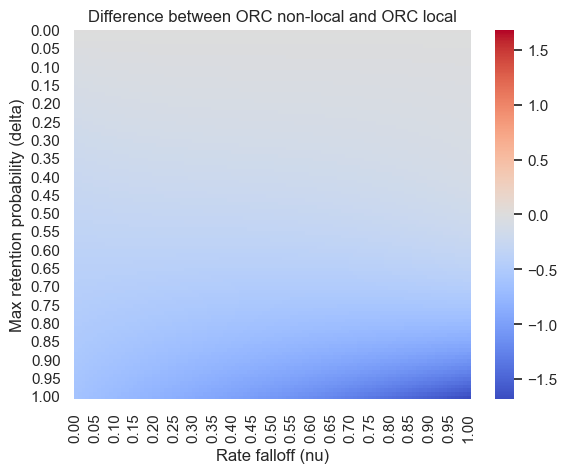

In [8]:
sns.heatmap(
    diffs_orcs_russian,
    xticklabels = xticklabels,
    yticklabels = yticklabels,
    cmap = "coolwarm",
    norm = norm
).set(
    title = "Difference between ORC non-local and ORC local",
    xlabel = "Rate falloff (nu)",
    ylabel = "Max retention probability (delta)"
);

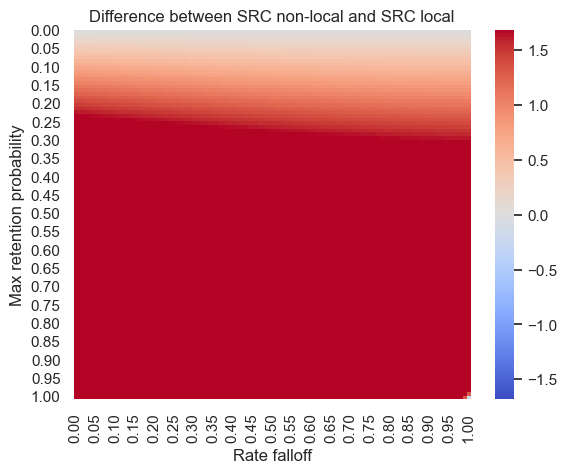

In [9]:
sns.heatmap(
    diffs_srcs_russian,
    xticklabels = xticklabels,
    yticklabels = yticklabels,
    cmap = "coolwarm",
    norm = norm
).set(
    title = "Difference between SRC non-local and SRC local",
    xlabel = "Rate falloff",
    ylabel = "Max retention probability"
);

Levy et al. (2013) also looked at the reading time on accusative NPs (in the grammar called 'DO'), and found that these were read slower when placed preverbally than postverbally.

0.9196247424528667


101it [02:30,  1.49s/it]


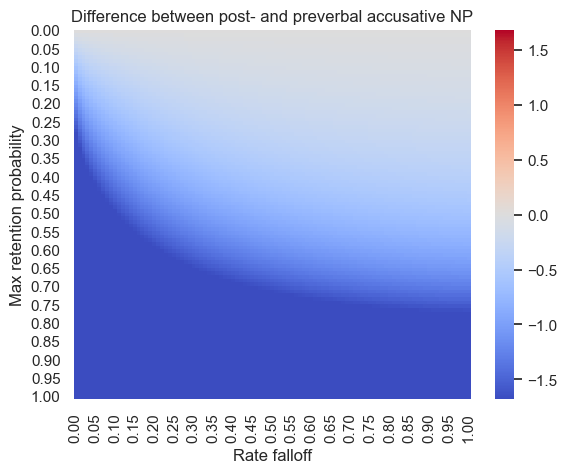

In [10]:
preverbal_acc = model_russian.calculate_processing_difficulty("RPNom DO".split())
postverbal_acc = model_russian.calculate_processing_difficulty("RPNom V DO".split())

diff = preverbal_acc - postverbal_acc
print(diff)

diffs_acc_np_russian = gen_diffs("RPNom V DO".split(), "RPNom DO".split(), pcfg_russian, max_retention_probabilities, rate_falloffs, max_depth = max_depth)

sns.heatmap(
    diffs_acc_np_russian,
    xticklabels = xticklabels,
    yticklabels = yticklabels,
    cmap = "coolwarm",
    norm = norm
).set(
    title = "Difference between post- and preverbal accusative NP",
    xlabel = "Rate falloff",
    ylabel = "Max retention probability"
);

As we can see from this output, the model predicts that preverbal accusative NPs have a higher processing difficulty than postverbal accusative NPs. This is to be expected from an expectation-based standpoint, since, as Levy et al. discuss, local SRC configurations are much more common, meaning a comprehender should expect the word following the nominative relative pronoun to be a verb, not a direct object.

### Experiment 1b
Here, I only look at the case-synchretized conditions, which had the following results.

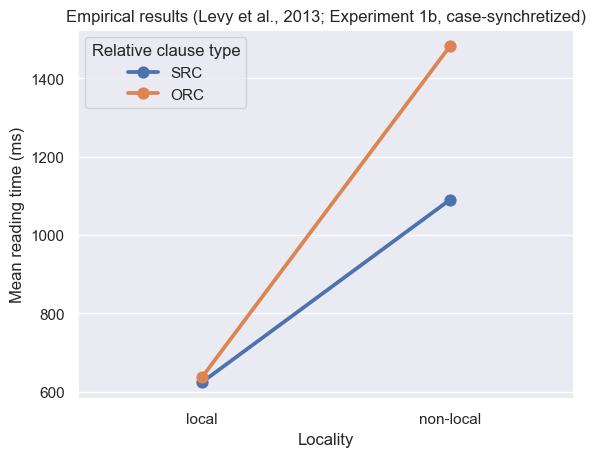

In [11]:
sns.pointplot(expdata.levy_exp1b_verb,
              x = "Locality", 
              y = "Mean reading time (ms)", 
              hue = "Relative clause type"
).set_title("Empirical results (Levy et al., 2013; Experiment 1b, case-synchretized)");

The model predicts the following.

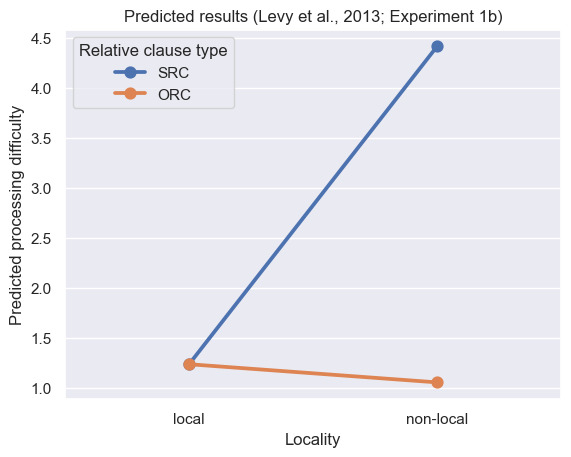

In [12]:
src_cs_local = model_russian.calculate_processing_difficulty("chto V".split(), False)
src_cs_non_local = model_russian.calculate_processing_difficulty("chto DO V".split(), False)

orc_cs_local = model_russian.calculate_processing_difficulty("chto V".split())
orc_cs_non_local = model_russian.calculate_processing_difficulty("chto Subj V".split(), False)

sim_data_exp1b = pd.DataFrame({
    "Predicted processing difficulty": [src_cs_local, src_cs_non_local, orc_cs_local, orc_cs_non_local],
    "Relative clause type": ["SRC", "SRC", "ORC", "ORC"],
    "Locality": ["local", "non-local", "local", "non-local"]
})

sns.pointplot(sim_data_exp1b,
              x = "Locality", 
              y = "Predicted processing difficulty", 
              hue = "Relative clause type"
).set_title("Predicted results (Levy et al., 2013; Experiment 1b)");

In [13]:
diffs_src_orc_cs = gen_diffs("chto DO V".split(), "chto Subj V".split(), pcfg_russian, max_retention_probabilities, rate_falloffs)

101it [03:25,  2.03s/it]


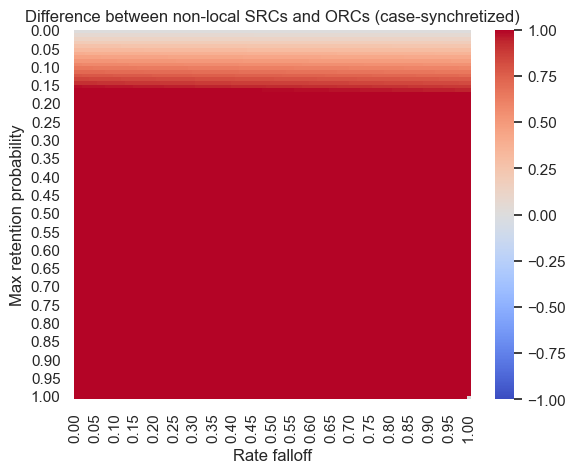

In [14]:
sns.heatmap(
    diffs_src_orc_cs,
    xticklabels = xticklabels,
    yticklabels = yticklabels,
    cmap = "coolwarm",
    vmin = -1,
    vmax = 1.0
).set(
    title = "Difference between non-local SRCs and ORCs (case-synchretized)",
    xlabel = "Rate falloff",
    ylabel = "Max retention probability"
);

## Experiment 2
The goal of the second experiment was to more directly manipulate the distance between the relative pronoun and the verb. They did this by adding one or two interveners that were either verb arguments (direct object + indirect object) or adjuncts. The results were the following.

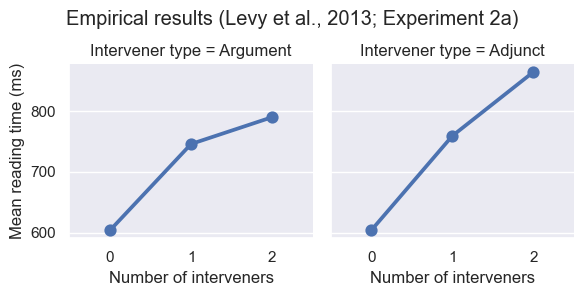

In [15]:
grid = sns.FacetGrid(expdata.levy_exp2a_verb, col = "Intervener type")

grid.map(sns.pointplot, "Number of interveners", "Mean reading time (ms)");
grid.figure.subplots_adjust(top = 0.8);
grid.figure.suptitle("Empirical results (Levy et al., 2013; Experiment 2a)");

In [16]:
no_intv = model_russian.calculate_processing_difficulty("RPNom V".split())
one_arg = model_russian.calculate_processing_difficulty("RPNom DO V".split())
two_arg = model_russian.calculate_processing_difficulty("RPNom DO IO V".split())

one_adj = model_russian.calculate_processing_difficulty("RPNom Adj1 V".split())
two_adj = model_russian.calculate_processing_difficulty("RPNom Adj1 Adj2 V".split())

sim_data_exp2 = pd.DataFrame({
    "Predicted processing difficulty": [no_intv, one_arg, two_arg, no_intv, one_adj, two_adj],
    "Number of interveners": [0, 1, 2, 0, 1, 2],
    "Intervener type": ["Argument", "Argument", "Argument", "Adjunct", "Adjunct", "Adjunct"]
})

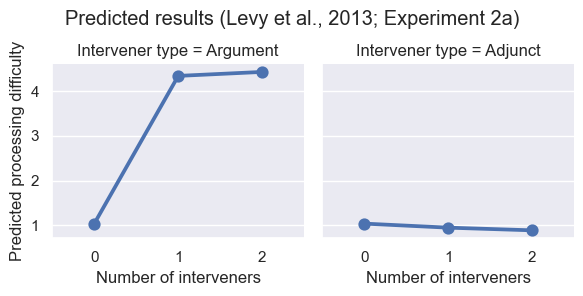

In [17]:
grid = sns.FacetGrid(sim_data_exp2, col = "Intervener type")
grid.map(sns.pointplot, "Number of interveners", "Predicted processing difficulty");
grid.figure.subplots_adjust(top = 0.8);
grid.figure.suptitle("Predicted results (Levy et al., 2013; Experiment 2a)");

In [18]:
print(model_russian.get_conditional_prob("RPNom V".split()))
print(model_russian.get_conditional_prob("RPNom Adj1 V".split()))
print(model_russian.get_conditional_prob("RPNom Adj1 Adj2 V".split()))

print(model_russian.get_conditional_prob("RPNom V".split()))
print(model_russian.get_conditional_prob("RPNom DO V".split()))
print(model_russian.get_conditional_prob("RPNom DO IO V".split()))

0.8315999999999999
0.9404999999999998
0.99
0.8315999999999999
0.9700000000000001
1.0


We can also have a look at the range of predictable effects.

In [19]:
diffs_arg1_zero = gen_diffs("RPNom DO V".split(), "RPNom V".split(), pcfg_russian, max_retention_probabilities, rate_falloffs, max_depth = max_depth)
diffs_arg2_arg1 = gen_diffs("RPNom DO IO V".split(), "RPNom DO V".split(), pcfg_russian, max_retention_probabilities, rate_falloffs, max_depth = max_depth)

diffs_adj1_zero = gen_diffs("RPNom Adj1 V".split(), "RPNom V".split(), pcfg_russian, max_retention_probabilities, rate_falloffs, max_depth = max_depth)
diffs_adj2_adj1 = gen_diffs("RPNom Adj1 Adj2 V".split(), "RPNom Adj1 V".split(), pcfg_russian, max_retention_probabilities, rate_falloffs, max_depth = max_depth)

101it [02:30,  1.49s/it]
101it [03:11,  1.90s/it]
101it [02:35,  1.54s/it]
101it [03:49,  2.27s/it]


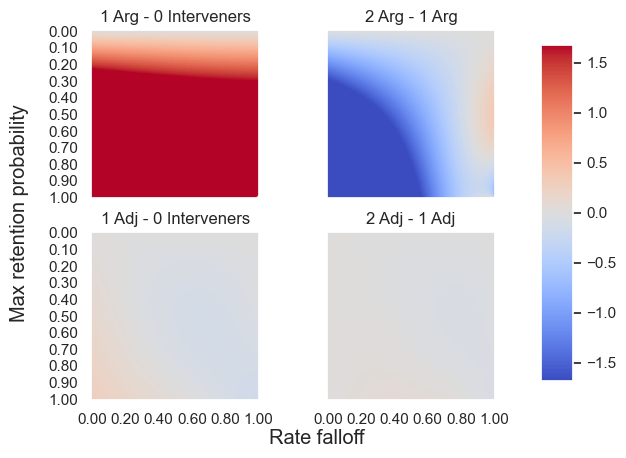

In [20]:
yticklabels_mulmaps = [f"{val:.2f}" if i % 10 == 0 else "" for (i, val) in enumerate(max_retention_probabilities)]
xticklabels_mulmaps = [f"{val:.2f}" if i % 20 == 0 else "" for (i, val) in enumerate(rate_falloffs)]

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)

im = axes[0,0].imshow(diffs_arg1_zero, cmap = "coolwarm", norm = norm)
axes[0,0].set(
    title = "1 Arg - 0 Interveners",
    xticks = np.arange(0, len(rate_falloffs)),
    xticklabels = xticklabels_mulmaps,
    yticks = np.arange(0, len(max_retention_probabilities)),
    yticklabels = yticklabels_mulmaps
)
axes[0,0].grid(False)

axes[0,1].imshow(diffs_arg2_arg1, cmap = "coolwarm", norm = norm)
axes[0,1].grid(False)
axes[0,1].set(
    title = "2 Arg - 1 Arg",
)

axes[1,0].imshow(diffs_adj1_zero, cmap = "coolwarm", norm = norm)
axes[1,0].grid(False)
axes[1,0].set(
    title = "1 Adj - 0 Interveners",
)

axes[1,1].imshow(diffs_adj2_adj1, cmap = "coolwarm", norm = norm)
axes[1,1].grid(False)
axes[1,1].set(
    title = "2 Adj - 1 Adj",
)

fig.subplots_adjust(right = 0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax = cbar_ax)

fig.supxlabel("Rate falloff")
fig.supylabel("Max retention probability")

plt.show()

# Strong expectations cancel locality effects: Evidence from Hindi
## Experiment 1
The first experiment was very similar to the first experiment of Levy et al. (2013), where verb locality was crossed with relative clause type. Hindi has some peculiarities: the non-local word order is canonical for both SRCs and ORCs, however, there is a chance that either the direct object or the subject is dropped. This 

In [21]:
pcfg_hindi = PCFG.fromstring(
    grammars.gen_hindi_grammar_exp1(
        p_src = 0.74,
        p_src_local = 0.01,
        p_obj_elision = 0.41,
        p_orc_local = 0.01,
        p_subj_elision = 0.98
    )
)

model_hindi = toylossy.ProgressiveNoiseModel(pcfg_hindi, max_retention_probability, rate_falloff)

The parameters were chosen based on the data from Husain et al. (2014). In a corpus study, the authors found a total of 345 relative clauses with a transitive verb. 248 of these were SRCs and 87 ORCs, giving $p(\text{SRC}) = \frac{248}{345}\approx 0.74$. Of the SRCs, only 2 had the non-canonical local word order, from which we get $p(\text{SRC}_\text{Local})=\frac{2}{248}\approx 0.01$. For ORCs, all 87 had the non-local configuration. In order to estimate $p(\text{ORC}_\text{Local})$ I perform Laplace smoothing by adding 1 to the frequency of both non-local and local ORCs, which gives $p(\text{ORC}_\text{Local})=\frac{1}{89}\approx 0.01$.

The elision probabilities are taken from the sentence completion study that the authors performed. They found in only 4 of 168 instances that the subject was produced in object-extracted relative claueses, giving us $p(\text{Subject elision})=\frac{168-4}{168}=\frac{164}{168}\approx 0.98$. Direct objects were however produced in 100 cases, giving $p(\text{Direct object elision})=\frac{68}{168}\approx 0.41$.

The reading times were as follows at the relative clause verb.

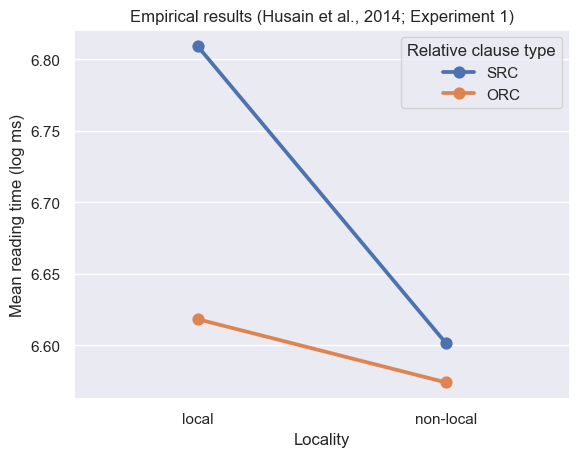

In [22]:
sns.pointplot(expdata.husain_exp1_verb,
              x = "Locality",
              y = "Mean reading time (log ms)",
              hue = "Relative clause type").set_title("Empirical results (Husain et al., 2014; Experiment 1)");

Let's look at the predicted data from the model.

In [23]:
src_local = model_hindi.calculate_processing_difficulty("RPErg V".split())
src_non_local  = model_hindi.calculate_processing_difficulty("RPErg DO V".split())

orc_local = model_hindi.calculate_processing_difficulty("RPAcc V".split())
orc_non_local  = model_hindi.calculate_processing_difficulty("RPAcc Subj V".split())

sim_husain_exp1_verb = pd.DataFrame({
    "Predicted processing difficulty": [src_local, src_non_local, orc_local, orc_non_local],
    "Relative clause type": ["SRC", "SRC", "ORC", "ORC"],
    "Locality": ["local", "non-local", "local", "non-local"]
})

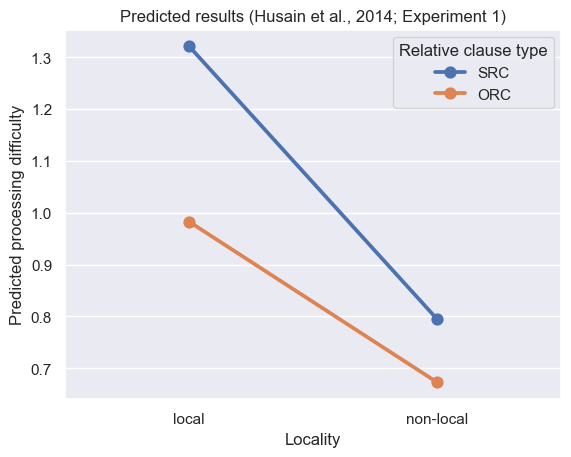

In [24]:
sns.pointplot(sim_husain_exp1_verb,
              x = "Locality",
              y = "Predicted processing difficulty",
              hue = "Relative clause type").set_title("Predicted results (Husain et al., 2014; Experiment 1)");

Let's check the predicted difference between non-local and local ORCs for different parameter combinations.

101it [00:05, 17.81it/s]


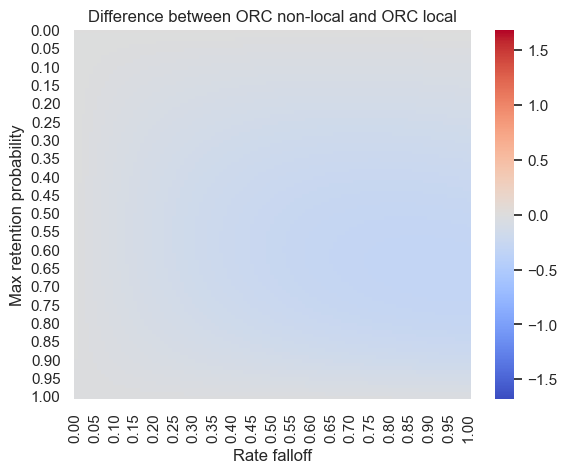

In [25]:
diffs_orcs_hindi = gen_diffs("RPAcc Subj V".split(), "RPAcc V".split(), pcfg_hindi, max_retention_probabilities, rate_falloffs)

sns.heatmap(
    diffs_orcs_hindi,
    xticklabels = xticklabels,
    yticklabels = yticklabels,
    cmap = "coolwarm",
    norm = norm
).set(
    title = "Difference between ORC non-local and ORC local",
    xlabel = "Rate falloff",
    ylabel = "Max retention probability"
);

This means that the model predicts a weak anti-locality effect at the verb in ORCs independent of the chosen parameter combination.

# Interaction between expectation and locality

Let's look at the data from Experiment 2 of Husain et al. and the study by Safavi et al.

In [26]:
pcfg_persian = PCFG.fromstring(
    grammars.gen_hindi_grammar_exp2(
        p_cp = 0.72,
        p_cp_intv = 0.0002,
        p_cp_short = 0.999,
        p_cp_lightverb = 0.64,
        p_sp_intv = 0.02,
        p_sp_short = 0.99,
        p_sp_lightverb = 0.33
    )
)

model_persian = toylossy.ProgressiveNoiseModel(pcfg_persian, max_retention_probability, rate_falloff)

Let's take a look at what the model predicts.

*Persian:*

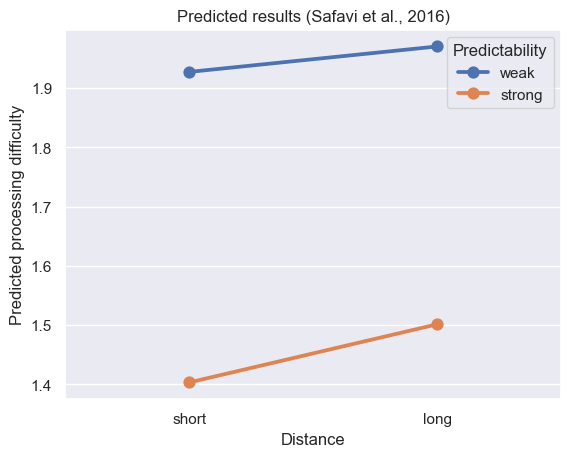

In [27]:
cp_short_persian = model_persian.calculate_processing_difficulty("CPNoun Adj1 LightVerb".split())
cp_long_persian  = model_persian.calculate_processing_difficulty("CPNoun Adj1 Adj2 LightVerb".split())
sp_short_persian = model_persian.calculate_processing_difficulty("SPNoun Adj1 LightVerb".split())
sp_long_persian  = model_persian.calculate_processing_difficulty("SPNoun Adj1 Adj2 LightVerb".split())

sim_data_persian = pd.DataFrame({
    "Predicted processing difficulty": [sp_short_persian, sp_long_persian, cp_short_persian, cp_long_persian],
    "Distance": ["short", "long", "short", "long"],
    "Predictability": ["weak", "weak", "strong", "strong"]
})

sns.pointplot(sim_data_persian,
              x = "Distance",
              y = "Predicted processing difficulty",
              hue = "Predictability").set_title("Predicted results (Safavi et al., 2016)");

In [28]:
diffs_preds_persian_cp = gen_diffs("CPNoun Adj1 Adj2 LightVerb".split(), "CPNoun Adj1 LightVerb".split(), pcfg_persian, max_retention_probabilities, rate_falloffs)
diffs_preds_persian_sp = gen_diffs("SPNoun Adj1 Adj2 LightVerb".split(), "SPNoun Adj1 LightVerb".split(), pcfg_persian, max_retention_probabilities, rate_falloffs)

101it [00:29,  3.37it/s]
101it [00:28,  3.50it/s]


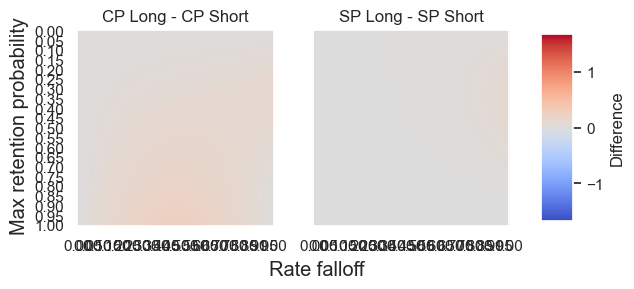

In [29]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

im = axes[0].imshow(diffs_preds_persian_cp, cmap = "coolwarm", norm = norm)
axes[0].grid(False)
axes[0].set(
    title = "CP Long - CP Short",
    xticks = np.arange(0, len(rate_falloffs)),
    xticklabels = xticklabels,
    yticks = np.arange(0, len(max_retention_probabilities)),
    yticklabels = yticklabels
)

axes[1].imshow(diffs_preds_persian_sp, cmap = "coolwarm", norm = norm)
axes[1].grid(False)
axes[1].set(
    title = "SP Long - SP Short",
)

fig.subplots_adjust(right = 0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.05, 0.39])
fig.colorbar(im, cax = cbar_ax).set_label("Difference")

xlabel = fig.supxlabel("Rate falloff")
xlabel.set_y(0.18)
ylabel = fig.supylabel("Max retention probability")

plt.show()

Let's do the same for Hindi.

In [30]:
pcfg_hindi_exp2 = PCFG.fromstring(
    grammars.gen_hindi_grammar_exp2(
        p_cp = 0.5,
        p_cp_intv = 0.05,
        p_cp_short = 0.99,
        p_cp_lightverb = 0.75,
        p_sp_intv = 0.06,
        p_sp_short = 0.99,
        p_sp_lightverb = 0.18
    )
)

model_hindi_exp2 = toylossy.ProgressiveNoiseModel(pcfg_hindi_exp2, max_retention_probability, rate_falloff)

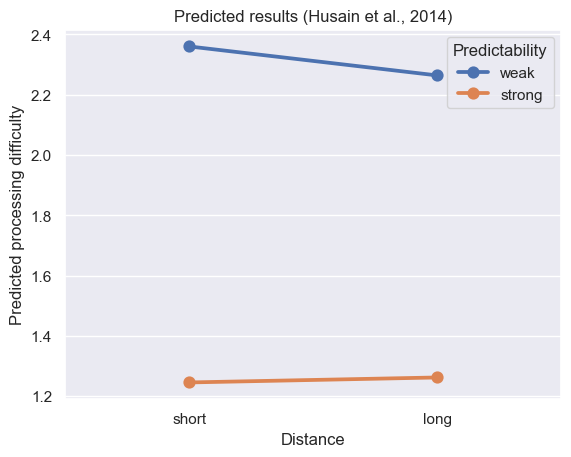

In [31]:
cp_short_hindi = model_hindi_exp2.calculate_processing_difficulty("CPNoun Adj1 LightVerb".split())
cp_long_hindi  = model_hindi_exp2.calculate_processing_difficulty("CPNoun Adj1 Adj2 LightVerb".split())
sp_short_hindi = model_hindi_exp2.calculate_processing_difficulty("SPNoun Adj1 LightVerb".split())
sp_long_hindi  = model_hindi_exp2.calculate_processing_difficulty("SPNoun Adj1 Adj2 LightVerb".split())

sim_data_hindi = pd.DataFrame({
    "Predicted processing difficulty": [sp_short_hindi, sp_long_hindi, cp_short_hindi, cp_long_hindi],
    "Distance": ["short", "long", "short", "long"],
    "Predictability": ["weak", "weak", "strong", "strong"]
})

sns.pointplot(sim_data_hindi,
              x = "Distance",
              y = "Predicted processing difficulty",
              hue = "Predictability").set_title("Predicted results (Husain et al., 2014)");

The prediction for Hindi is essentially the same.

Are there any parameters for which there is anti-locality for the predictable conditions?

In [32]:
diffs_preds_hindi_cp = gen_diffs("CPNoun Adj1 Adj2 LightVerb".split(), "CPNoun Adj1 LightVerb".split(), pcfg_hindi_exp2, max_retention_probabilities, rate_falloffs)
diffs_preds_hindi_sp = gen_diffs("SPNoun Adj1 Adj2 LightVerb".split(), "SPNoun Adj1 LightVerb".split(), pcfg_hindi_exp2, max_retention_probabilities, rate_falloffs)

101it [00:28,  3.57it/s]
101it [00:28,  3.60it/s]


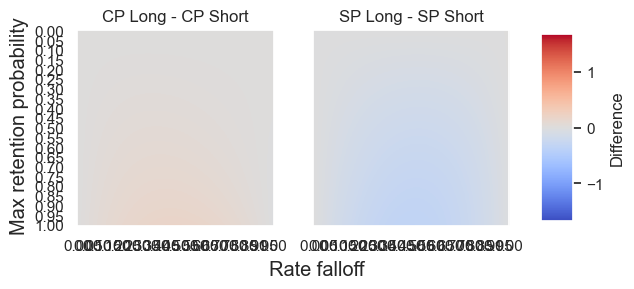

In [33]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

im = axes[0].imshow(diffs_preds_hindi_cp, cmap = "coolwarm", norm = norm)
axes[0].grid(False)
axes[0].set(
    title = "CP Long - CP Short",
    xticks = np.arange(0, len(rate_falloffs)),
    xticklabels = xticklabels,
    yticks = np.arange(0, len(max_retention_probabilities)),
    yticklabels = yticklabels
)

axes[1].imshow(diffs_preds_hindi_sp, cmap = "coolwarm", norm = norm)
axes[1].grid(False)
axes[1].set(
    title = "SP Long - SP Short",
)

fig.subplots_adjust(right = 0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.05, 0.39])
fig.colorbar(im, cax = cbar_ax).set_label("Difference")

xlabel = fig.supxlabel("Rate falloff")
xlabel.set_y(0.18)
ylabel = fig.supylabel("Max retention probability")

plt.show()

Can we find any parameter combination where there is a locality effect or zero difference for the weakly predictable condition but anti-locality for strongly predictable conditions?

In [34]:
desired_params = []

for i in range(len(max_retention_probabilities)):
    for j in range(len(rate_falloffs)):
        if diffs_preds_persian_cp[i, j] < 0.0 and diffs_preds_persian_sp[i, j] >= 0.0:
            desired_params.append((max_retention_probabilities[i], rate_falloffs[j]))

print(len(desired_params))
print(desired_params)

0
[]


In [35]:
if len(desired_params) == 0:
    raise Exception("No such parameter combination!")

model_hindi_exp2.set_max_retention_probability(desired_params[0][0])
model_hindi_exp2.set_rate_falloff(desired_params[0][1])

cp_short_hindi = model_hindi_exp2.calculate_processing_difficulty("CPNoun Adj LightVerb".split())
cp_long_hindi  = model_hindi_exp2.calculate_processing_difficulty("CPNoun Adj Adj LightVerb".split())
sp_short_hindi = model_hindi_exp2.calculate_processing_difficulty("SPNoun Adj LightVerb".split())
sp_long_hindi  = model_hindi_exp2.calculate_processing_difficulty("SPNoun Adj Adj LightVerb".split())

sim_data_hindi = pd.DataFrame({
    "Predicted processing difficulty": [sp_short_hindi, sp_long_hindi, cp_short_hindi, cp_long_hindi],
    "Distance": ["short", "long", "short", "long"],
    "Predictability": ["weak", "weak", "strong", "strong"]
})

sns.pointplot(sim_data_hindi,
              x = "Distance",
              y = "Predicted processing difficulty",
              hue = "Predictability").set_title("Predicted results (Husain et al., 2014)");

Exception: No such parameter combination!

In [ ]:
print(cp_long_hindi - cp_short_hindi)
print(sp_long_hindi - sp_short_hindi)

-0.06968979880838644
0.22679089241532813


# Per-word predictions
Just for fun, here are some per-word predictions.

0.9378782880922019
0.4489023938408906
0.4489023938408906
0.12029423371771177
0.12029423371771177
0.0
-0.0
0.23209100476774194
0.23209100476774194
0.23209100476774194
0.23209100476774194
0.014499569695115252
0.014499569695115252


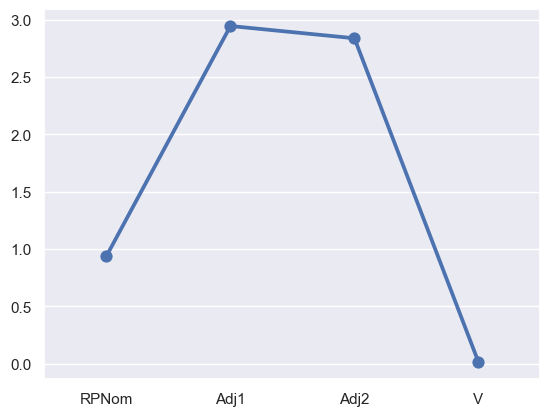

In [ ]:
sequence = "RPNom Adj1 Adj2 V".split()

sns.pointplot(
    x = np.arange(1, len(sequence)+1),
    y = model_russian.calculate_sequence_processing_difficulty(sequence),
).set(
    xticklabels = sequence
);

model_russian.set_max_retention_probability(max_retention_probability)
model_russian.set_rate_falloff(rate_falloff)

print(model_russian.calculate_processing_difficulty(["RPNom"]))

model_russian.set_max_retention_probability(1.0)
model_russian.set_rate_falloff(1.0)

print(model_russian.calculate_processing_difficulty("RPNom V".split()))
print(-np.log2(model_russian.get_conditional_prob("RPNom V".split())))

print(model_russian.calculate_processing_difficulty("RPNom DO V".split()))
print(-np.log2(model_russian.get_conditional_prob("RPNom DO V".split())))

print(model_russian.calculate_processing_difficulty("RPNom DO IO V".split()))
print(-np.log2(model_russian.get_conditional_prob("RPNom DO IO V".split())))

print(model_russian.calculate_processing_difficulty("RPNom Adj1 V".split()))
print(-np.log2(model_russian.get_conditional_prob("RPNom Adj1 V".split())))

print(model_russian.calculate_processing_difficulty("RPNom Adj2 V".split()))
print(-np.log2(model_russian.get_conditional_prob("RPNom Adj2 V".split())))

print(model_russian.calculate_processing_difficulty("RPNom Adj1 Adj2 V".split()))
print(-np.log2(model_russian.get_conditional_prob("RPNom Adj1 Adj2 V".split())))

In [ ]:
print(-np.log2(model_russian.get_conditional_prob("RPNom V".split())))

0.4489023938408906


# PML Queries

# Russian
## SRCs


## ORCs
### Local word order

Result: 7

### Non-local word order

Result: 20

$p(\text{ORC}_{\text{Local}})=\frac{7}{27}=0.6$